# Outline

## Identification

Gabriel Kazuyuki | 9793673

Juliano Garcia de Oliveira | 9277086

Matheus Tararam de Laurentys | 9793714

## Name of the dataset
Dataset: Women's Shoe Prices

## Abstract
This dataset contains Women's shoe product information, mainly the prices, brands, etc. Interestingly, it also has some images


The original dataset is provided by the Datafiniti company, and as we don't have access to a premium API, I'm using a sample of it, that I found on kaggle. 

## Questions to the dataset
Question 1: Which categories have the highest price?

Question 2: Is there a pattern to the colors depending on the brand or price?

Question 3: Which brands have the lowest ratings?

Question 4: What is the percentage of shoes which the prices changed?

Question 5: What is the number of shoes which there is difference between the minimum and maximum prices?

Question 6: What is the mean of the prices of the shoes added each month of the year?

# Setup

## Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell #display full output instead of just the last one
InteractiveShell.ast_node_interactivity = "all"

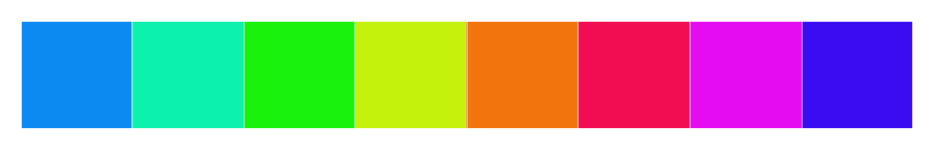

In [15]:
import toolz as fp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import string
from pprint import pprint
import functools
import operator
import string
from fuzzywuzzy import fuzz
from matplotlib import colors as mcolors
sns.set()
%matplotlib inline
pd.set_option('display.max_rows', 50)
palette = sns.hls_palette(8, h=.7, s=.9, l=0.5)
sns.palplot(palette[::-1])
sns.set_palette(palette[::-1])

gray = "444444"

plt.rcParams['figure.facecolor'] = '1'  # background color
plt.rcParams['axes.facecolor'] = '1'  # plot background color

plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.alpha'] = .4

plt.rcParams['axes.edgecolor'] = '1'

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.linestyle'] = '-'

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelcolor'] = gray

plt.rcParams['text.color'] = gray

plt.rcParams['xtick.color'] = gray
plt.rcParams['ytick.color'] = gray
sns.set_style("whitegrid")
sns.set_context("notebook")
%config InlineBackend.figure_format = "retina"

In [16]:
def new_axis(figsize=(15, 8), title=None):
    """
    Creates a new matplotlib axis and returns it
    Parameters
    ----------
    figsize : Tuple(Numeric, Numeric)
        the figure size
    title : str
        the figure title
    """
    _, ax = plt.subplots(figsize=figsize)
    if title is not None:
        ax.set_title(title, size=17)
    return ax

## Load Dataset

In [17]:
df1 = pd.read_csv("womens-shoes-prices/7210_1.csv")
df1.columns = pd.Index(map(lambda c: c.replace(".", "_"), df1.columns)) # replace names for better ones
df1 = df1.drop(columns=[col for col in df1.columns if "Unnamed" in col]) # remove unnamed columns
df1 = df1.query("prices_currency == 'USD'") # remove non USD for simplicity. The majority of the prices are in USD
df1.shape

(32680, 48)

In [18]:
df1.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'count', 'dateAdded',
       'dateUpdated', 'descriptions', 'dimension', 'ean', 'features',
       'flavors', 'imageURLs', 'isbn', 'keys', 'manufacturer',
       'manufacturerNumber', 'merchants', 'name', 'prices_amountMin',
       'prices_amountMax', 'prices_availability', 'prices_color',
       'prices_condition', 'prices_count', 'prices_currency',
       'prices_dateAdded', 'prices_dateSeen', 'prices_flavor', 'prices_isSale',
       'prices_merchant', 'prices_offer', 'prices_returnPolicy',
       'prices_shipping', 'prices_size', 'prices_source', 'prices_sourceURLs',
       'prices_warranty', 'quantities', 'reviews', 'sizes', 'skus',
       'sourceURLs', 'upc', 'vin', 'websiteIDs', 'weight'],
      dtype='object')

## Helper Code and Data Cleanup

In [19]:
# Auxiliary methods

def get_review_texts(el):
    try:
        dict_review = json.loads(el)
        return " ENDMSG ".join(map(lambda rev: rev.get("text", ""), dict_review))
    except (TypeError, json.JSONDecodeError, KeyError) as e:
        return np.nan

def get_review_ratings(el):
    try:
        dict_review = json.loads(el)
        reviews_list = list(map(lambda rev: rev.get("rating", np.nan), dict_review))
        if all(np.isnan(reviews_list)):
            return np.nan
        return reviews_list
    except (TypeError, json.JSONDecodeError, KeyError) as e:
        return np.nan

def clean_merchant(el):
    try:
        if ".com" in el and " " in el:
            return el[::-1][:el[::-1].find(" ")][::-1].lower()
        return el.lower()
    except TypeError:
        return np.nan

In [20]:
# Adds  a column that contains list of colors

df1 = df1.assign(
    lower_brand=lambda df: df.brand.str.lower(),
    clean_merchant=lambda df: df.prices_merchant.apply(clean_merchant),
    list_colors=lambda df: df.colors.str.lower().str.split(","),
    list_categories=lambda df: df.categories
    .str.lower()
    .str.replace(" ", "")
    .str.split(",")
    .apply(lambda el: map(lambda x: x.translate(str.maketrans("", "", string.punctuation)), el))
    .apply(lambda el: list(filter(None, el))),
    review_texts=lambda df: np.where(df.reviews.notna(), df.reviews.apply(get_review_texts), np.nan),
    review_ratings=lambda df: np.where(df.reviews.notna(), df.reviews.apply(get_review_ratings), np.nan),
)

# Questions

## Question 1

I prefer looking at the cumulative distribution in the data, rather than only the histogram. The ECDF gives much more information than the histogram, we can readily check for outliers based on the percentile we're looking at. For more reference, I suggest reading [this](https://en.wikipedia.org/wiki/Empirical_distribution_function) -:)

In [21]:
from statsmodels.distributions.empirical_distribution import ECDF

def plot_column_distribution(values, name):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
    values_ecdf = ECDF(values)
    mapped_ecdf = values_ecdf(values)
    median = values[sorted(enumerate(mapped_ecdf), key=lambda el: np.abs(el[1] - .5))[0][0]]
    ax[0].plot(values, mapped_ecdf, color="b")
    ax[0].legend(labels=[f"{name} ECDF"], loc=4)
    ax[0].scatter(median, 0.5, color="g", s=70)
    ax[0].annotate(f"Median = {median}",
            xy=(median, 0.5),
            xytext=(50, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')

    sns.distplot(values, ax=ax[1], color="r")
    ax[1].legend(labels=[f"{name} histogram"], loc=4)
    fig.suptitle(f"{name} distribution", size=18)

We can check that approx. 90% of the products have their mean prices bounded in the interval 0 - 500 USD, and few outliers with very high prices, but they're less than 2% of our dataset

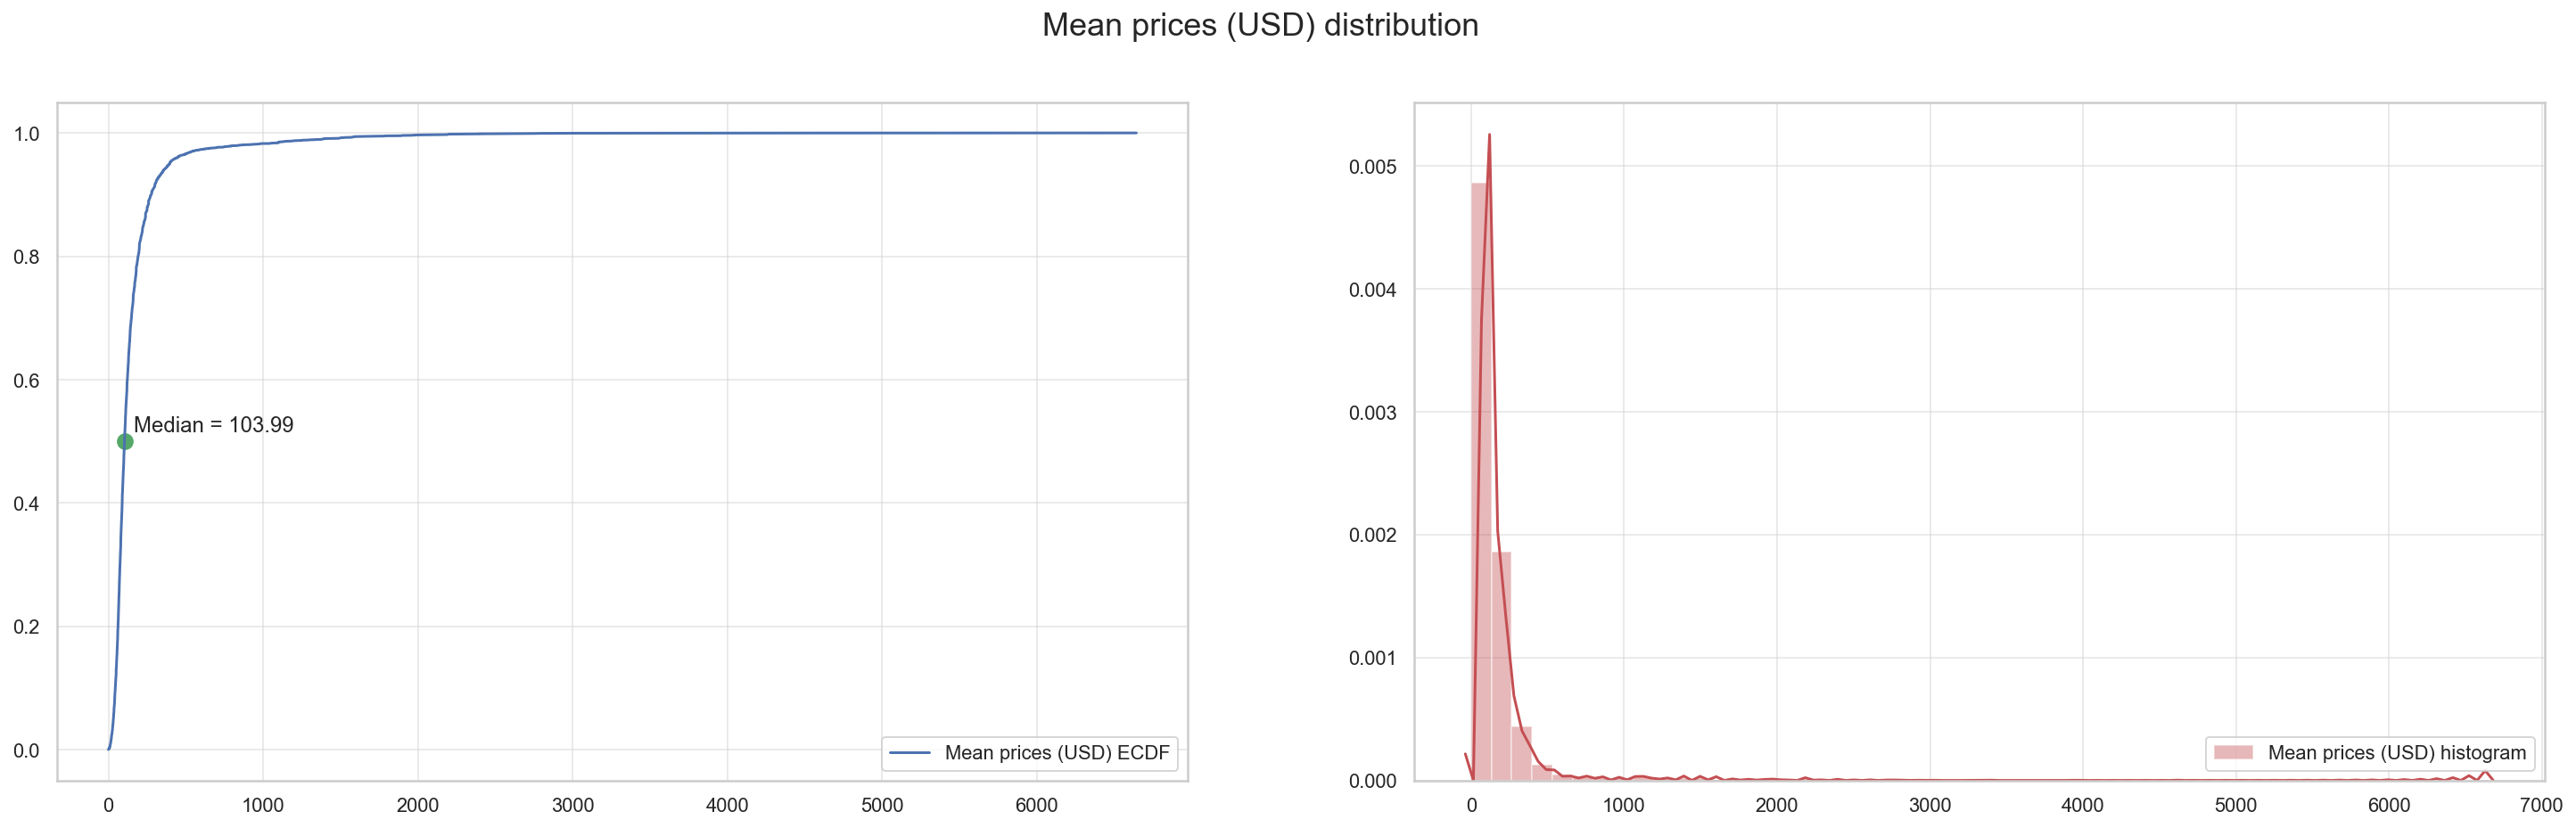

In [22]:
prices_dist = df1.groupby("id").apply(lambda g: (g.prices_amountMin + g.prices_amountMax).mean()).sort_values().values
plot_column_distribution(prices_dist, name="Mean prices (USD)")


**Most significant brands in the dataset**

By checking the TOP 25 brands with the highest price ratio and price delta, we see that the first one, `jewelsobsession`, is 1st in both of them. by name, I don't think this sells shoes only, so I'll check manually the names of the product it sells and visualize it.

It's also worth noting that `jewelsobsession` is an outlier of the **price_ratio** variable, which indicates that its products are the ones with the highest prices.

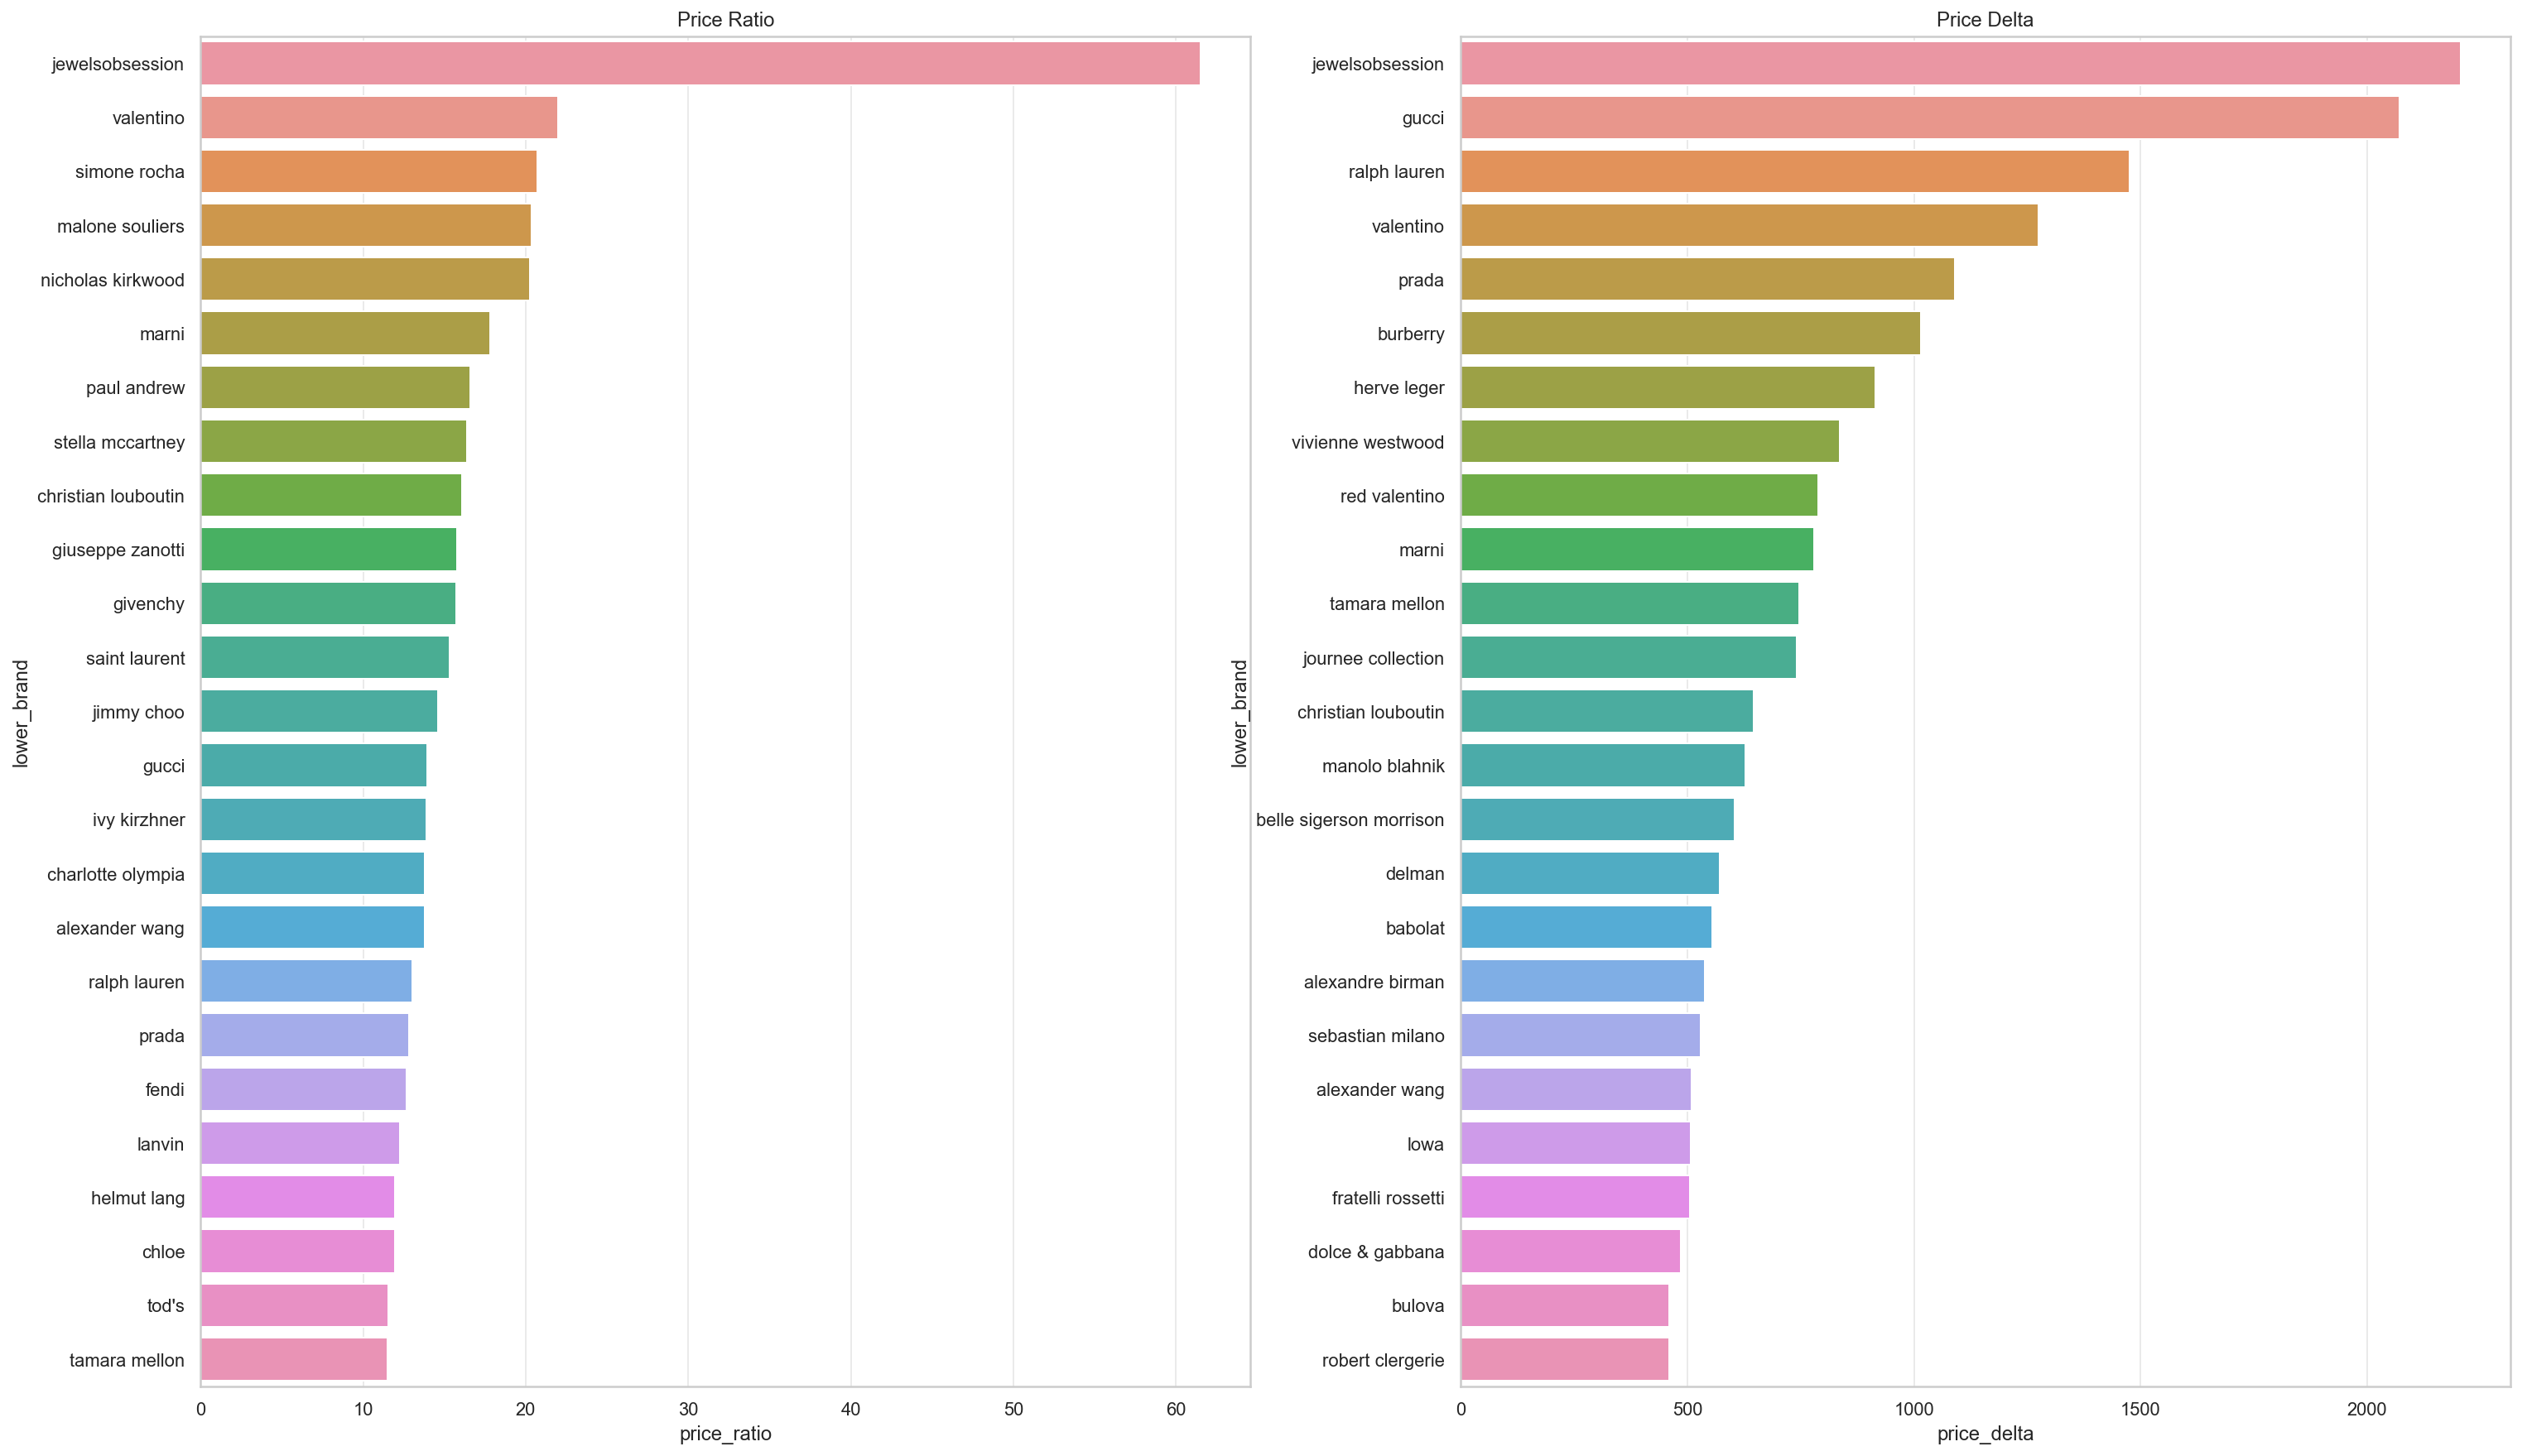

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))
sns.barplot(
    x="price_ratio",
    y="lower_brand",
    data=df1.groupby("lower_brand")
    .apply(lambda g: g.prices_amountMax.sum() / g.size)
    .rename("price_ratio")
    .sort_values(ascending=False)
    .reset_index().head(25),
    ax=ax[0],
    orient="h"
)

sns.barplot(
    x="price_delta",
    y="lower_brand",
    data=df1.groupby("lower_brand")
    .apply(lambda g: g.prices_amountMax.max() - g.prices_amountMin.min())
    .rename("price_delta")
    .sort_values(ascending=False)
    .reset_index().head(25),
    ax=ax[1],
    orient="h"
)

ax[0].set_title("Price Ratio"), ax[1].set_title("Price Delta");

By the name of it, these products do not seem to be shoes...

In [24]:
df1.query("lower_brand == 'jewelsobsession'").name

21219    Diamond Eternity Band
21220    Diamond Eternity Band
21221    Diamond Eternity Band
21222    Diamond Eternity Band
21223    Diamond Eternity Band
Name: name, dtype: object

We'll now check by product category the prices and the frequency of each category.

We see that the highest price averages are related to jewelry (so this dataset doesn't contains only shoes >:( ), designer specific products, collections, etc; Which does makes sense.

However when checking the frequency of each category, we see that the majority of them are shoes, and doesn't appear a lot in the most expensive categories

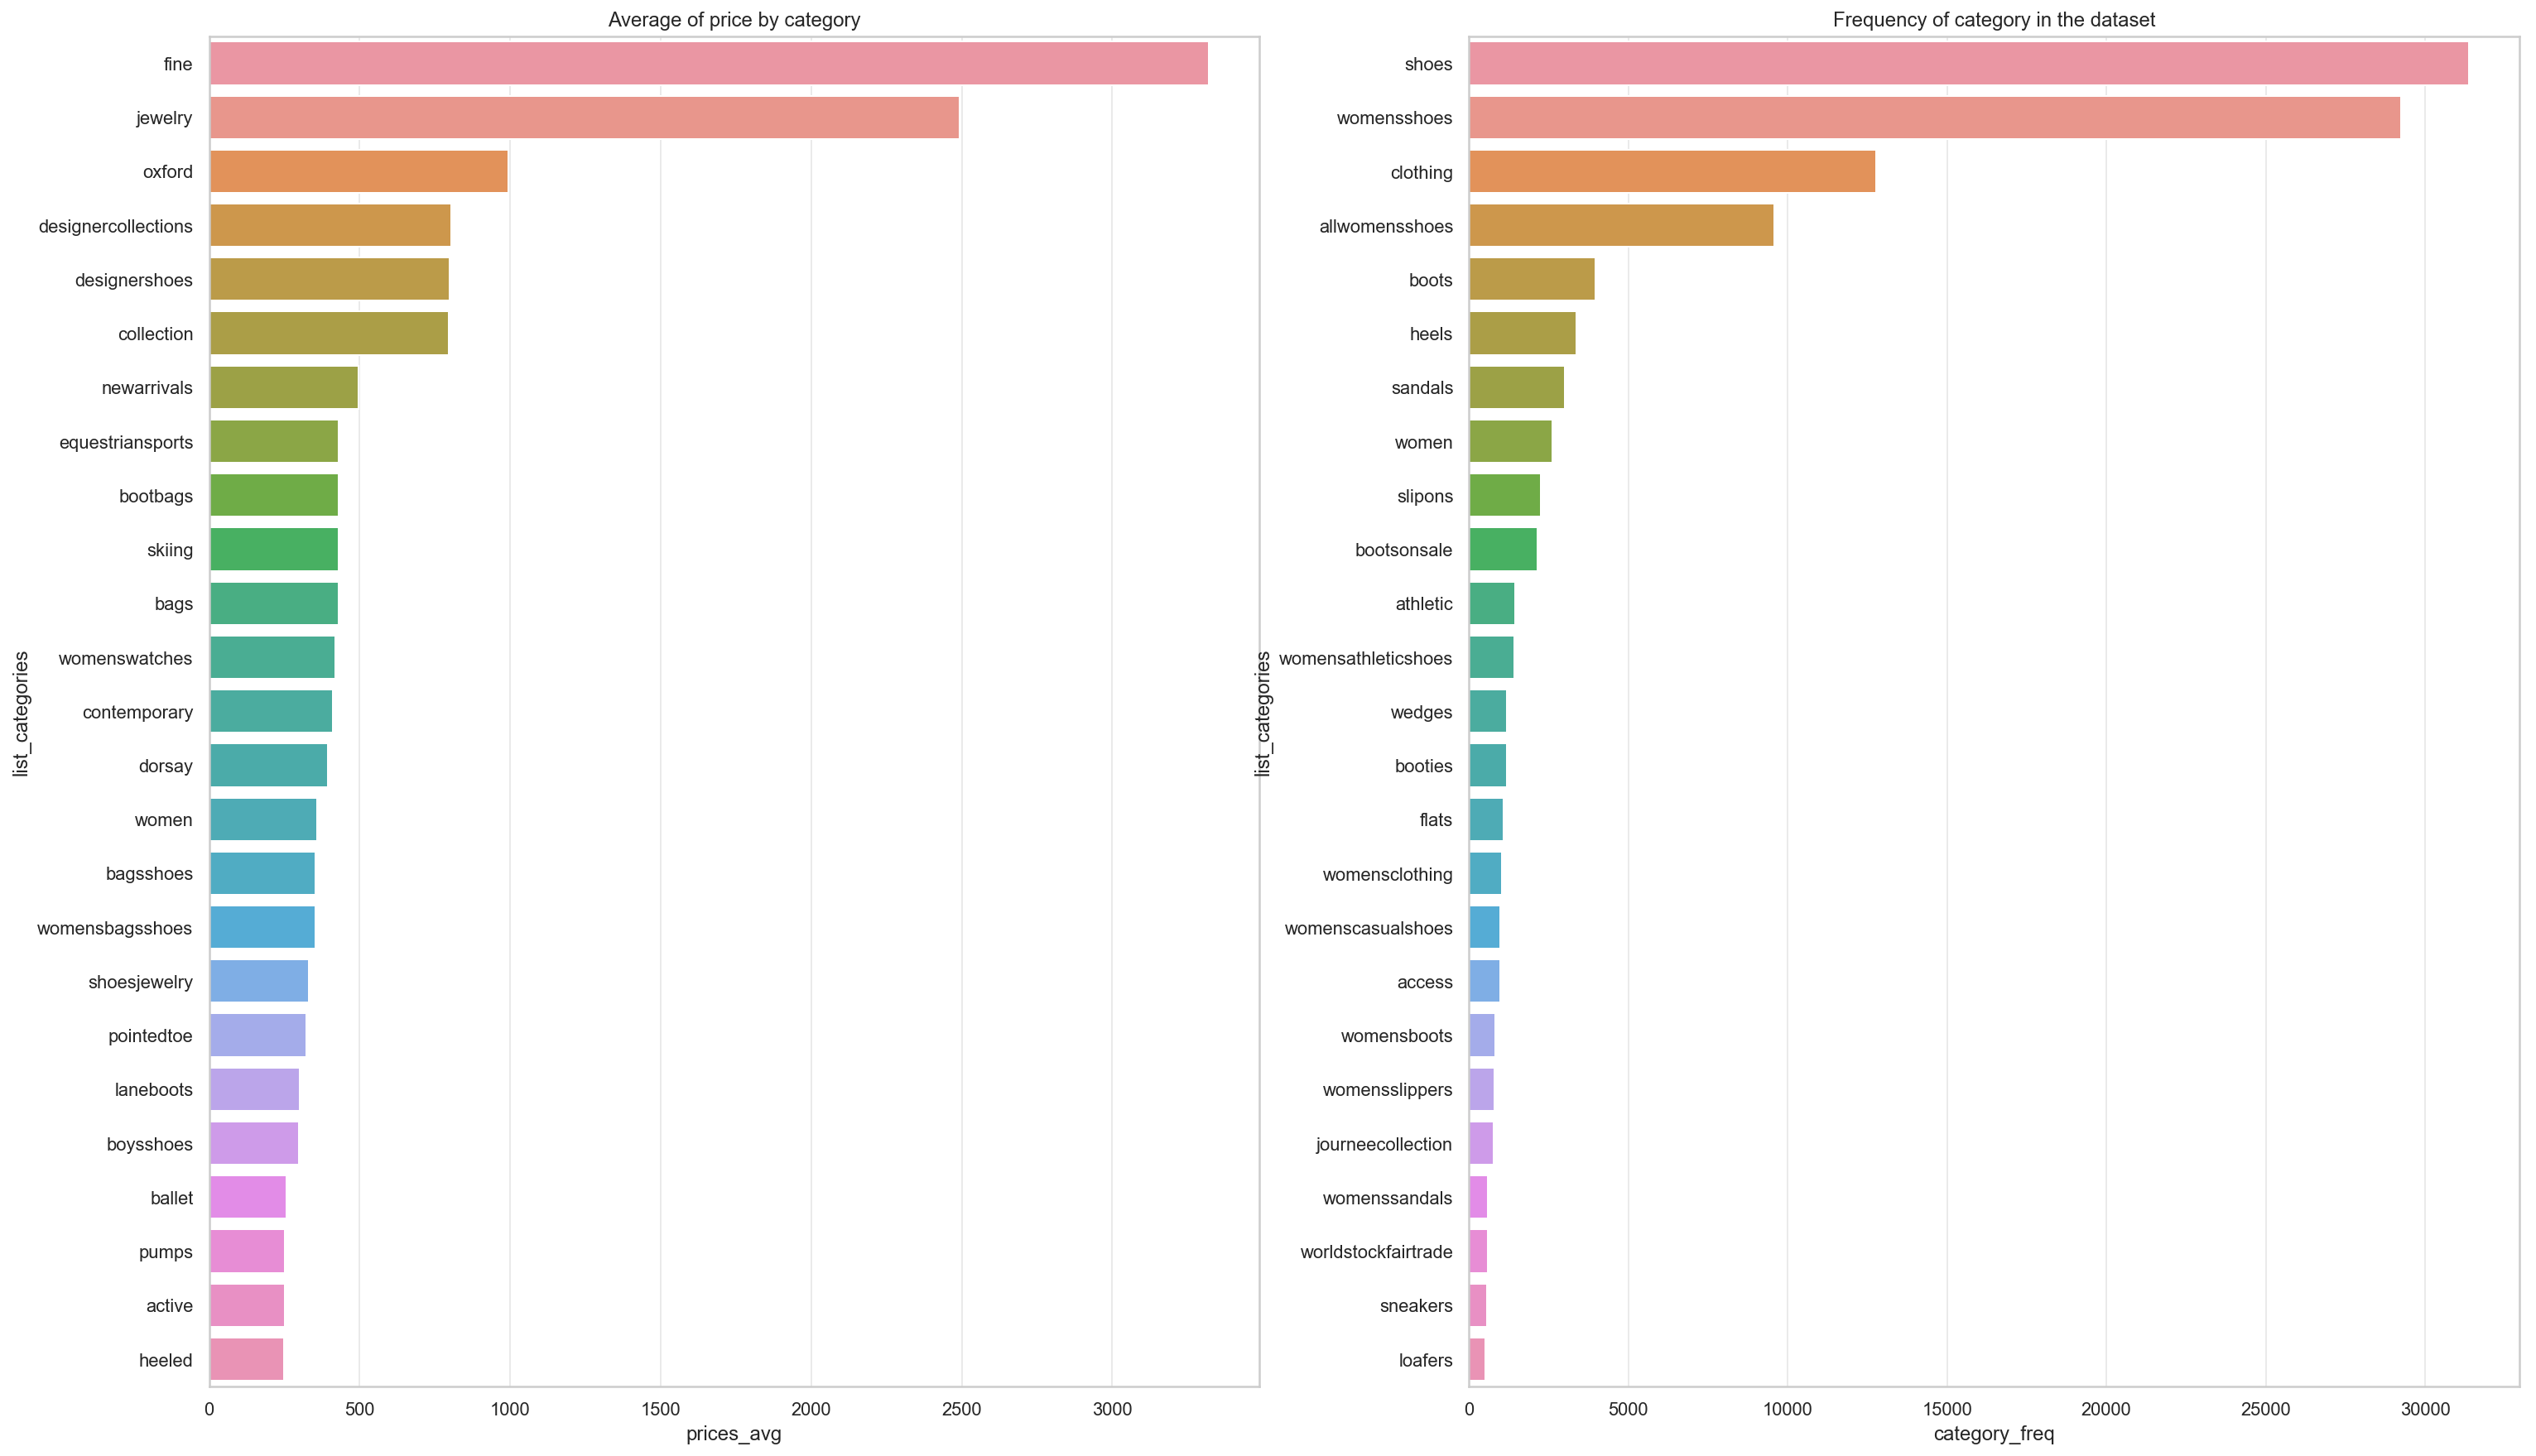

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

sns.barplot(
    x="prices_avg",
    y="list_categories",
    data=(
        df1.explode("list_categories")
        .groupby("list_categories")
        .apply(lambda g: g.prices_amountMax.mean())
        .sort_values(ascending=False)
        .iloc[:25]
        .rename("prices_avg").reset_index()
    ),
    orient="h",
    ax=ax[0]
)
sns.barplot(
    x="category_freq",
    y="list_categories",
    data=(
        df1.explode("list_categories")
        .groupby("list_categories").id
        .count()
        .sort_values(ascending=False)
        .iloc[:25]
        .rename("category_freq").reset_index()
    ),
    orient="h",
    ax=ax[1]
)
ax[0].set_title("Average of price by category"), ax[1].set_title("Frequency of category in the dataset");

What are the categories that most appear in the highest price ratio brands?

We see again that there's fine goods, designer shoes, designer collections, jewelry, etc!

### 3. Some categories evaluation

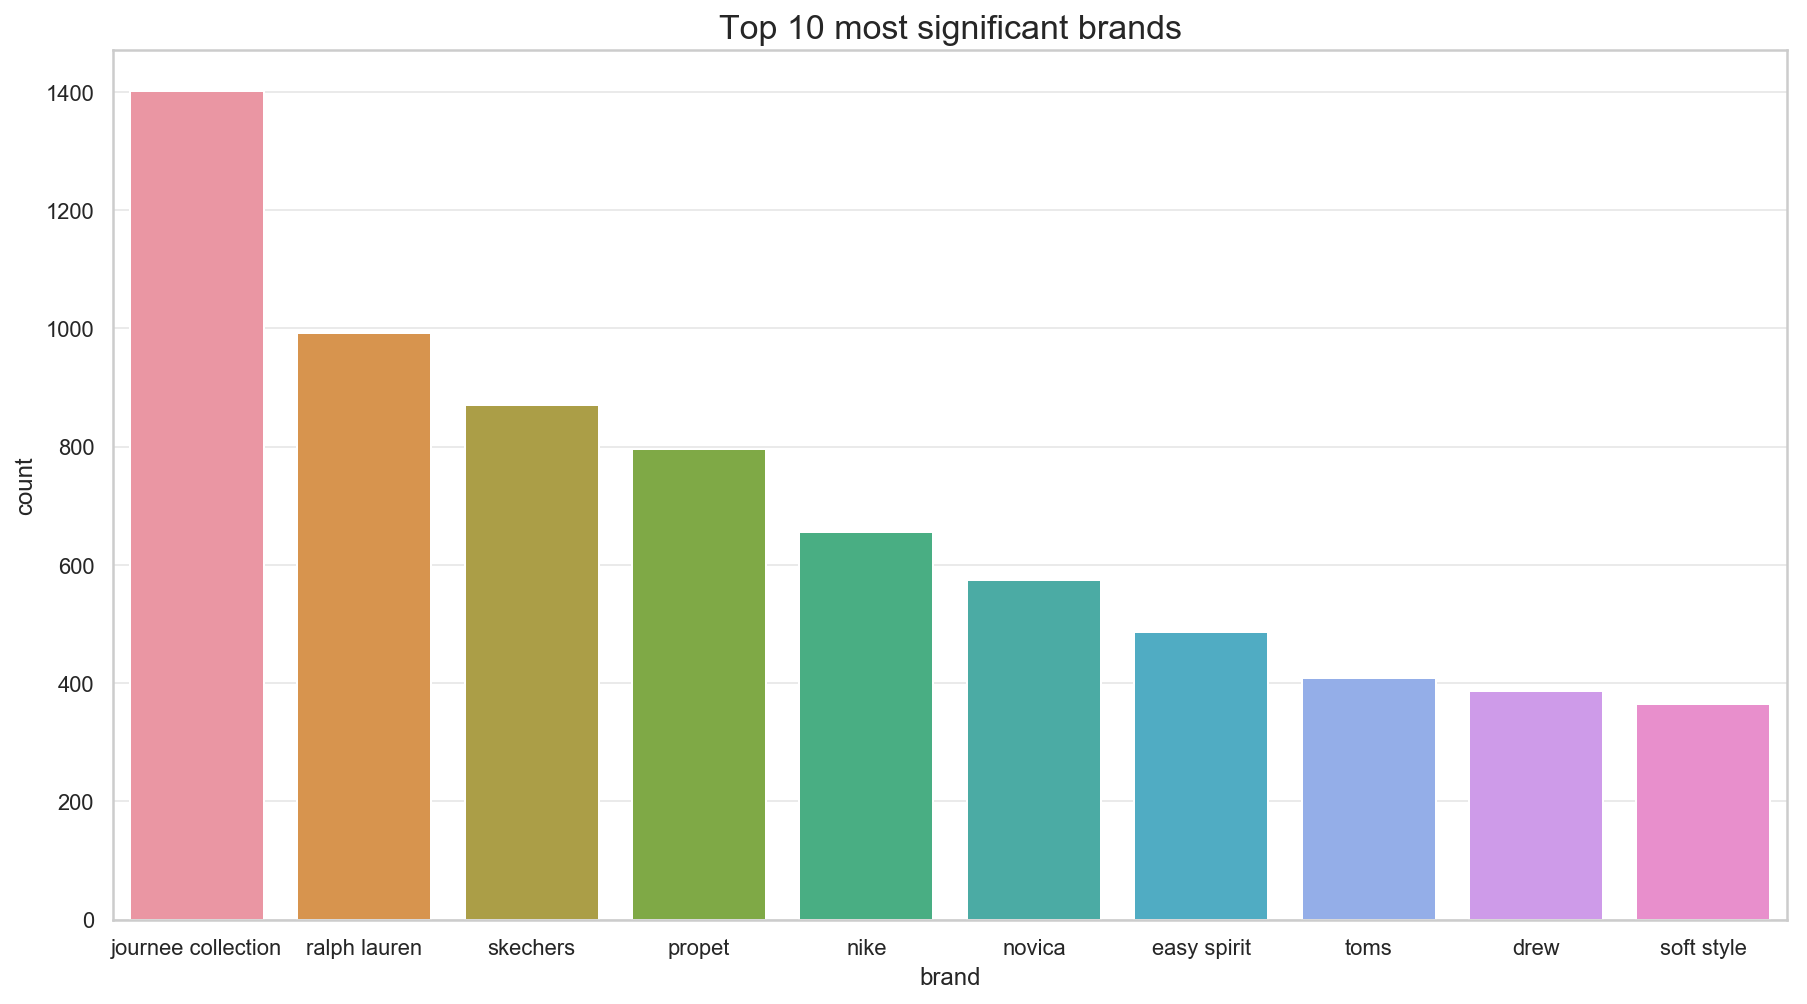

In [26]:
sns.barplot(
    x="brand",
    y="count",
    data=df1.lower_brand.value_counts()
    .head(10)
    .reset_index()
    .rename(columns={"index": "brand", "lower_brand": "count"}),
    ax=new_axis(title="Top 10 most significant brands"),
)

## Question 2

One interesting thing I want to check is how are the colors of the products depending on the price.
Here I do a fuzzy matching to try to get the correct color and plot some of them.

In [27]:
def flatlist(a):
    return functools.reduce(operator.concat, a)

 # INSTALL python-Levenshtein!!!
def colors_grad(df):
    # return the relative frequency of each color of a brand
    list_colors = df.list_colors.dropna().values
    matplot_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

    def find_best_color_match(c):
        return sorted(matplot_colors.items(), key=lambda tup: -fuzz.ratio(tup[0], c))[0][1]

    if len(list_colors) > 0:
        list_colors = list(
            map(
                lambda x: x.replace(" ", "").translate(str.maketrans("", "", string.punctuation)), flatlist(list_colors)
            )
        )
        return {find_best_color_match(color): list_colors.count(color) for color in list_colors}
    return np.nan
brands_color_map = df1.groupby("lower_brand").apply(colors_grad).dropna().rename("color_map").reset_index()

In [28]:
from collections import Counter
from functools import reduce
def sum_all_colors(df):
    return reduce(lambda x, y: Counter(x) + Counter(y), df.color_map.values)

In [29]:
dataset_with_color_map = df1.merge(brands_color_map.dropna(), on="lower_brand", how="inner").query("lower_brand != 'unbranded'")
most_expensive_brands = dataset_with_color_map.groupby("lower_brand").apply(lambda x: x.prices_amountMax.mean()).sort_values(ascending=False).iloc[:100].index
least_expensive_brands = dataset_with_color_map.groupby("lower_brand").apply(lambda x: x.prices_amountMax.mean()).sort_values().iloc[:100].index

In [30]:
most_expensive_colors = sum_all_colors(brands_color_map.query("lower_brand in @most_expensive_brands"))
least_expensive_colors = sum_all_colors(brands_color_map.query("lower_brand in @least_expensive_brands"))

In [31]:
def plot_color_barplot(df, title):
    df_aux = pd.DataFrame(sorted(list(df.items()), key=lambda t: -t[1])[:20], columns=["hex", "count"])
    sns.set_context(rc={"patch.linewidth": 1.0})
    sns.barplot(
        x="hex",
        y="count",
        data=df_aux,
        palette=sns.color_palette(df_aux.hex.values),
        ax=new_axis(figsize=(25, 10), title=title),
        edgecolor="k",
    )

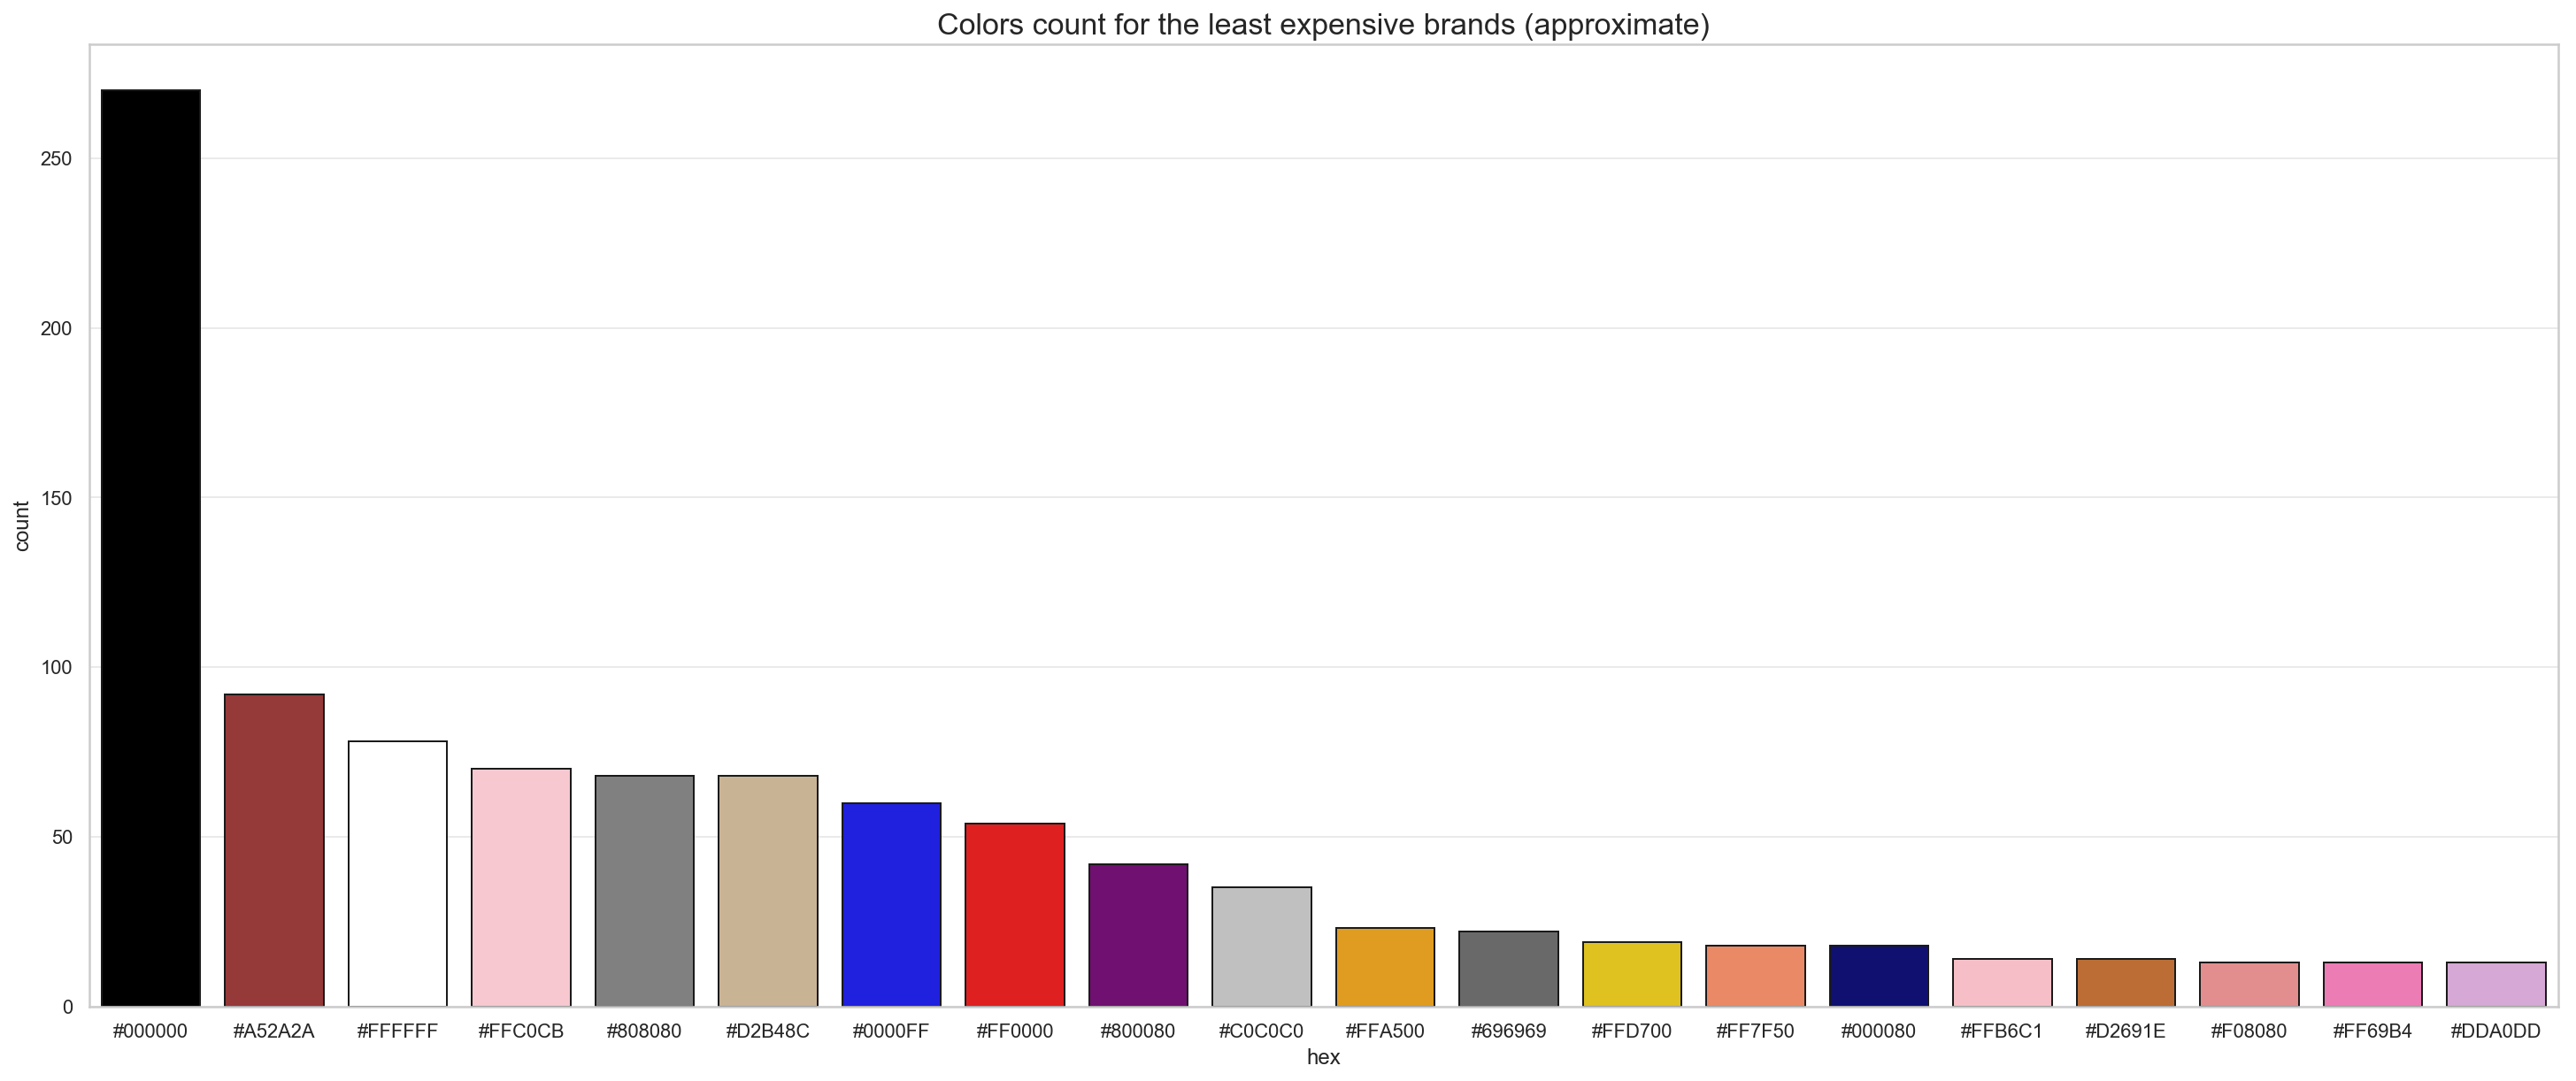

In [32]:
plot_color_barplot(least_expensive_colors, title="Colors count for the least expensive brands (approximate)")

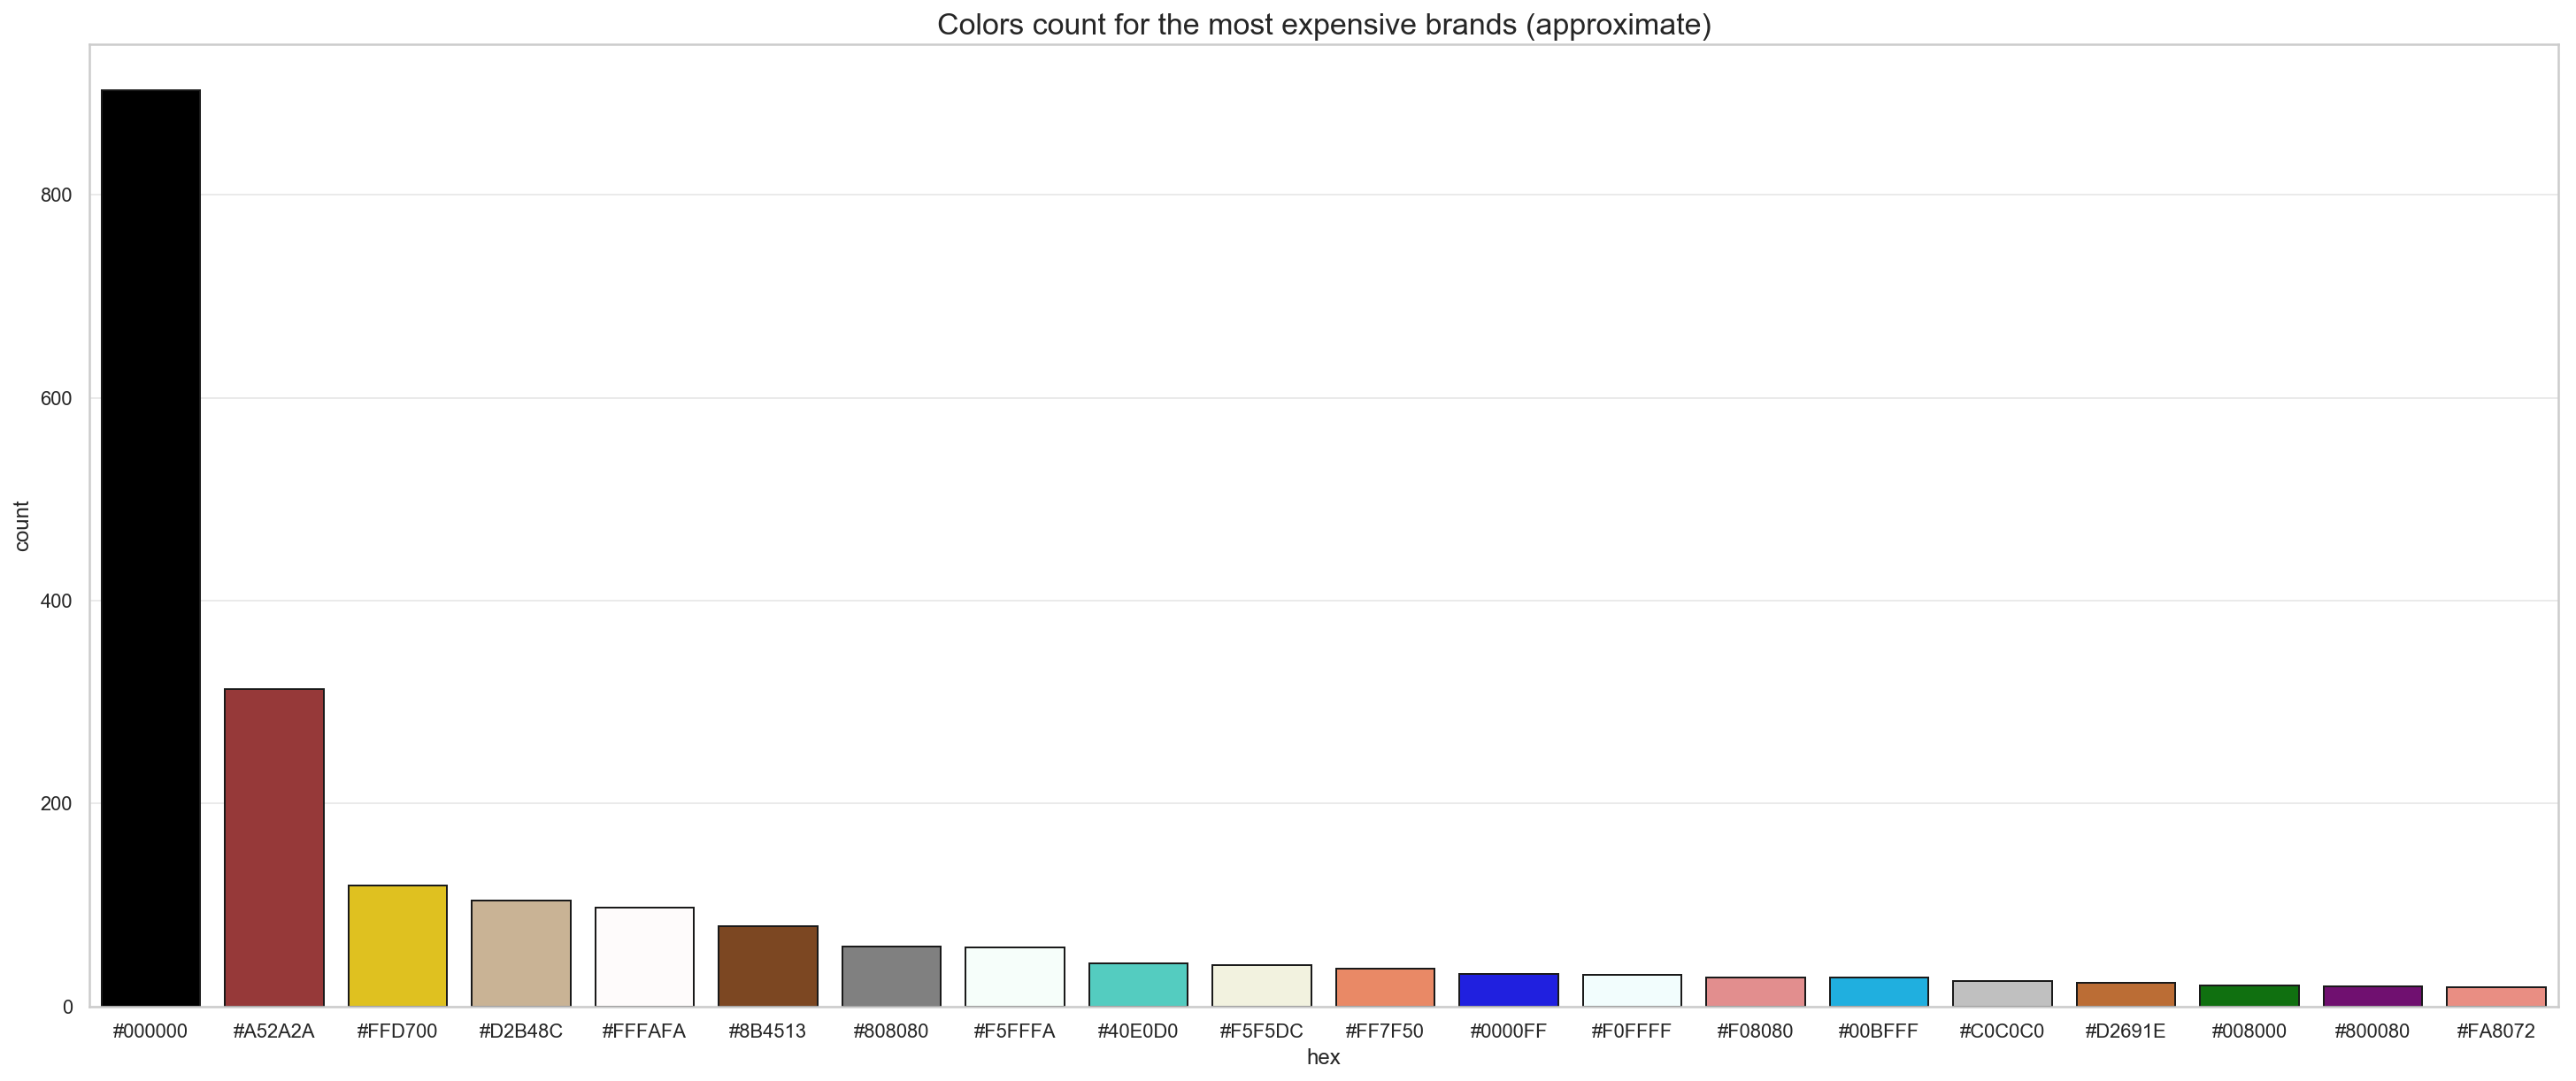

In [33]:
plot_color_barplot(most_expensive_colors, title="Colors count for the most expensive brands (approximate)")

Black and Brown are the most predominant colors. From this approximate plot, it seems like the least expensive brands have more pink, red and blue; One reason for this can be the presence of athletics products, which usually have this color.

## Question 3

I wanted to know which brands have the best and the worst reviews, so I'm checking this here!

However, please note that from all the 30k rows, only about 2k of them have reviews, and a lot of products also have some NaN ratings, so this analysis applies only to a subset of the women's shoes dataset!

Nonetheless, the brands I found are mostly unknown. For example, from those I only know Asics and Ugg.

(114, 2)


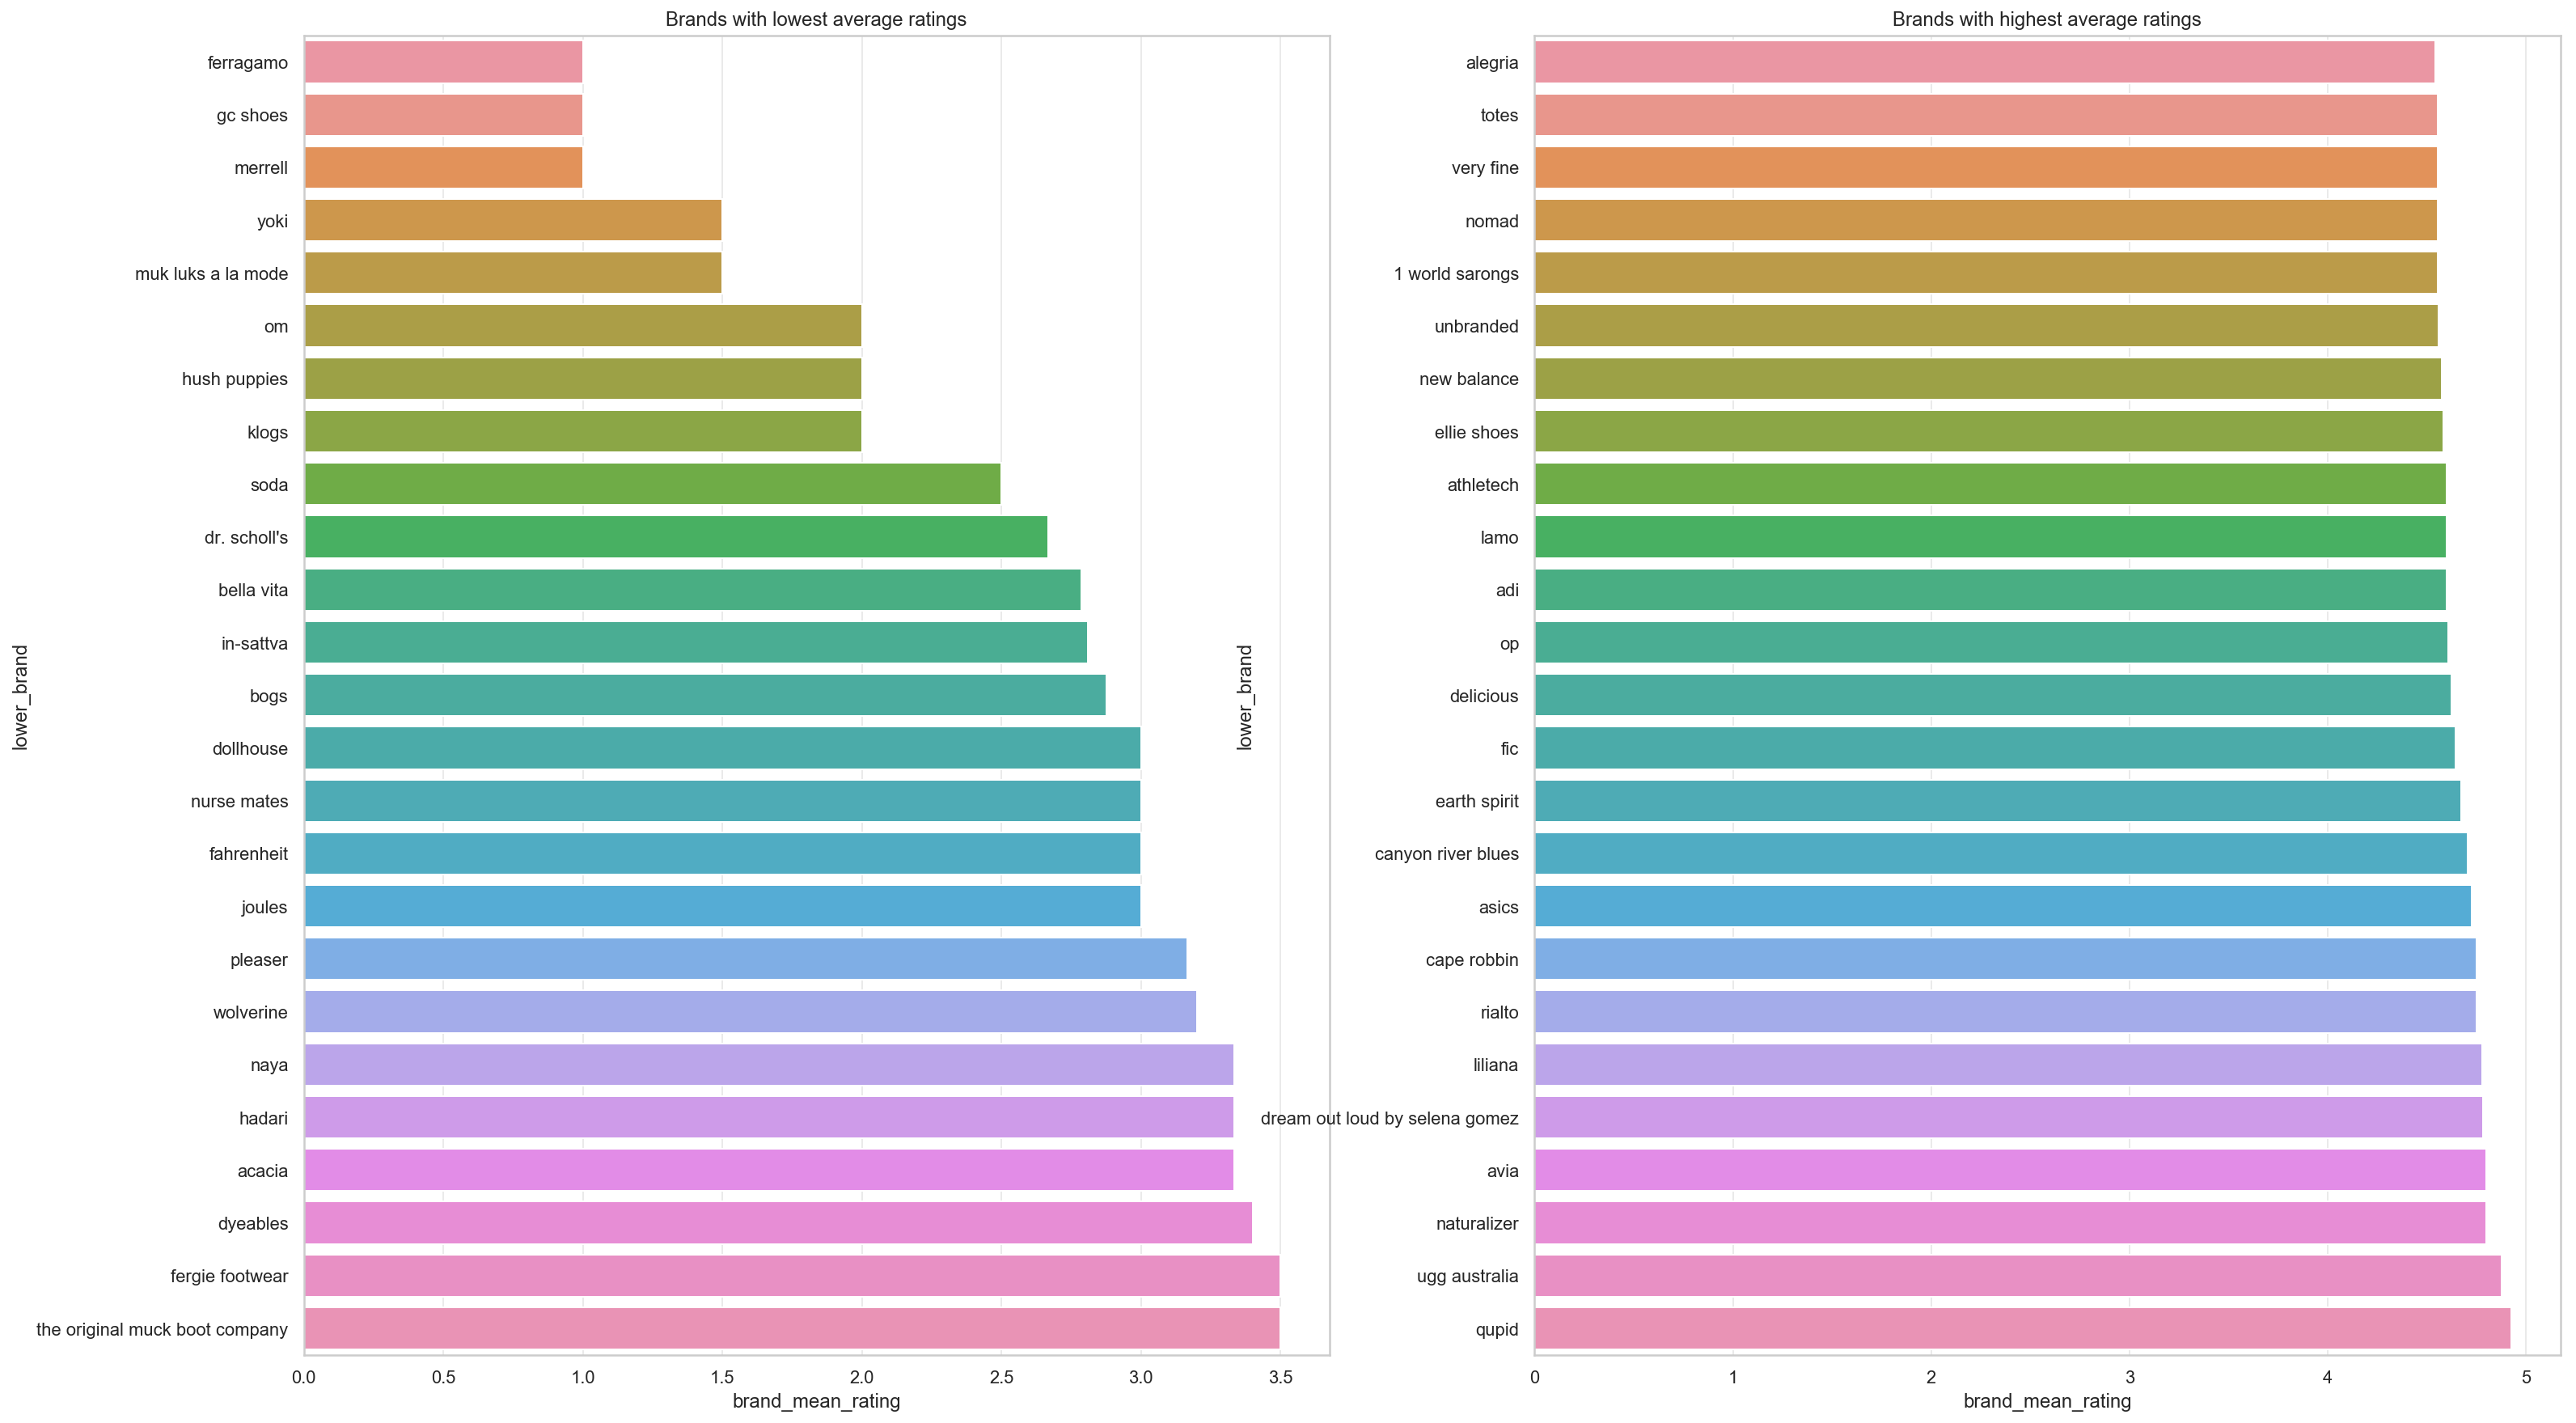

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

brand_mean_ratings = (
    df1[df1.review_ratings.notna()]
    .assign(
        mean_rating=lambda df: df.review_ratings.apply(
            lambda list_e: np.mean(list(filter(lambda el: not np.isnan(el), list_e)))
        )
    )
    .groupby("id")
    .first()
    .groupby("lower_brand")
    .apply(lambda df: np.mean(df.mean_rating))
    .rename("brand_mean_rating")
    .reset_index()
    .sort_values(by="brand_mean_rating")
    .query("brand_mean_rating < 5")


)
print(brand_mean_ratings.shape)
sns.barplot(x="brand_mean_rating", y="lower_brand", data=brand_mean_ratings.iloc[:25], ax=ax[0])
sns.barplot(x="brand_mean_rating", y="lower_brand", data=brand_mean_ratings.iloc[-25:], ax=ax[1])
ax[0].set_title("Brands with lowest average ratings"), ax[1].set_title("Brands with highest average ratings");

## Question 4

In order to verify if the products information were updated with time, and not just added by the group making the datase, it is important to know what is the percentage of entries that have different costs. It is expected that the percentage is somewhat large for products available for a long time, because it is common for product's prices to change.

Since the dataframe is not mantained, oldest update is in 2017, let's assume that a old value is one that is older than the median of the dateAdded column. Another observation is that it is expected that products will very fast stop being fabricated, so it is not expected that their price change date range will be large.

Next, we check this information:
0. Get median of dateAdded values.
1. We get all the products that are available for longer than the median (ids). (This is meant to give a bound for the hypotesis that the prices should change if they are old)
2. From these products we check those that have more than one entry. 
3. From the one's that changed we check those whose amountMax or amountMin changed. 

In [35]:
#calculates median - all values from 2017 or before
def getDate(entry):
    sDate = entry["dateAdded"]
    def age(date):
        return 100 * (int(date[0:4]) - 2010)
    def getMonth(date):
        d = int(date[5:7])
        return d
    val = 0
    val += age(sDate)
    val += getMonth(sDate)
    return val

median = np.median(df1.assign(numDate=lambda df: df.apply(getDate, axis=1)).numDate.values)

def isOld(date):
    return getDate(date) < median #conservative (does not include products with the same year/month as the median)

def category_is_old(df):
    return any(df["is_old"].values)

def category_is_large(df):
    return df.shape[0] > 1

def price_is_changed(df):
    return (df.prices_amountMin.value_counts().size != 1) | (df.prices_amountMax.value_counts().size != 1)


(
    df1.assign(is_old=lambda df: df1.apply(isOld, axis=1))
            .groupby("id")
            .filter(category_is_old)
            .groupby("id")
            .filter(category_is_large)
            .groupby("id")
            .apply(price_is_changed).value_counts()    
)

True     2799
False     102
dtype: int64

From this analysis we know that almost all shoes were updated in this dataframe. Since few were not, and it is expected that some shoes stop being fabricated, we can trust that companied updated their prices in this set, as they were changed.

## Question 5

656 Shoes have a different price!

In [36]:
df1.query("prices_amountMax - prices_amountMin > 0.0").id.size

656

## Question 6

Text(0.5, 1.0, 'Mean price by date')

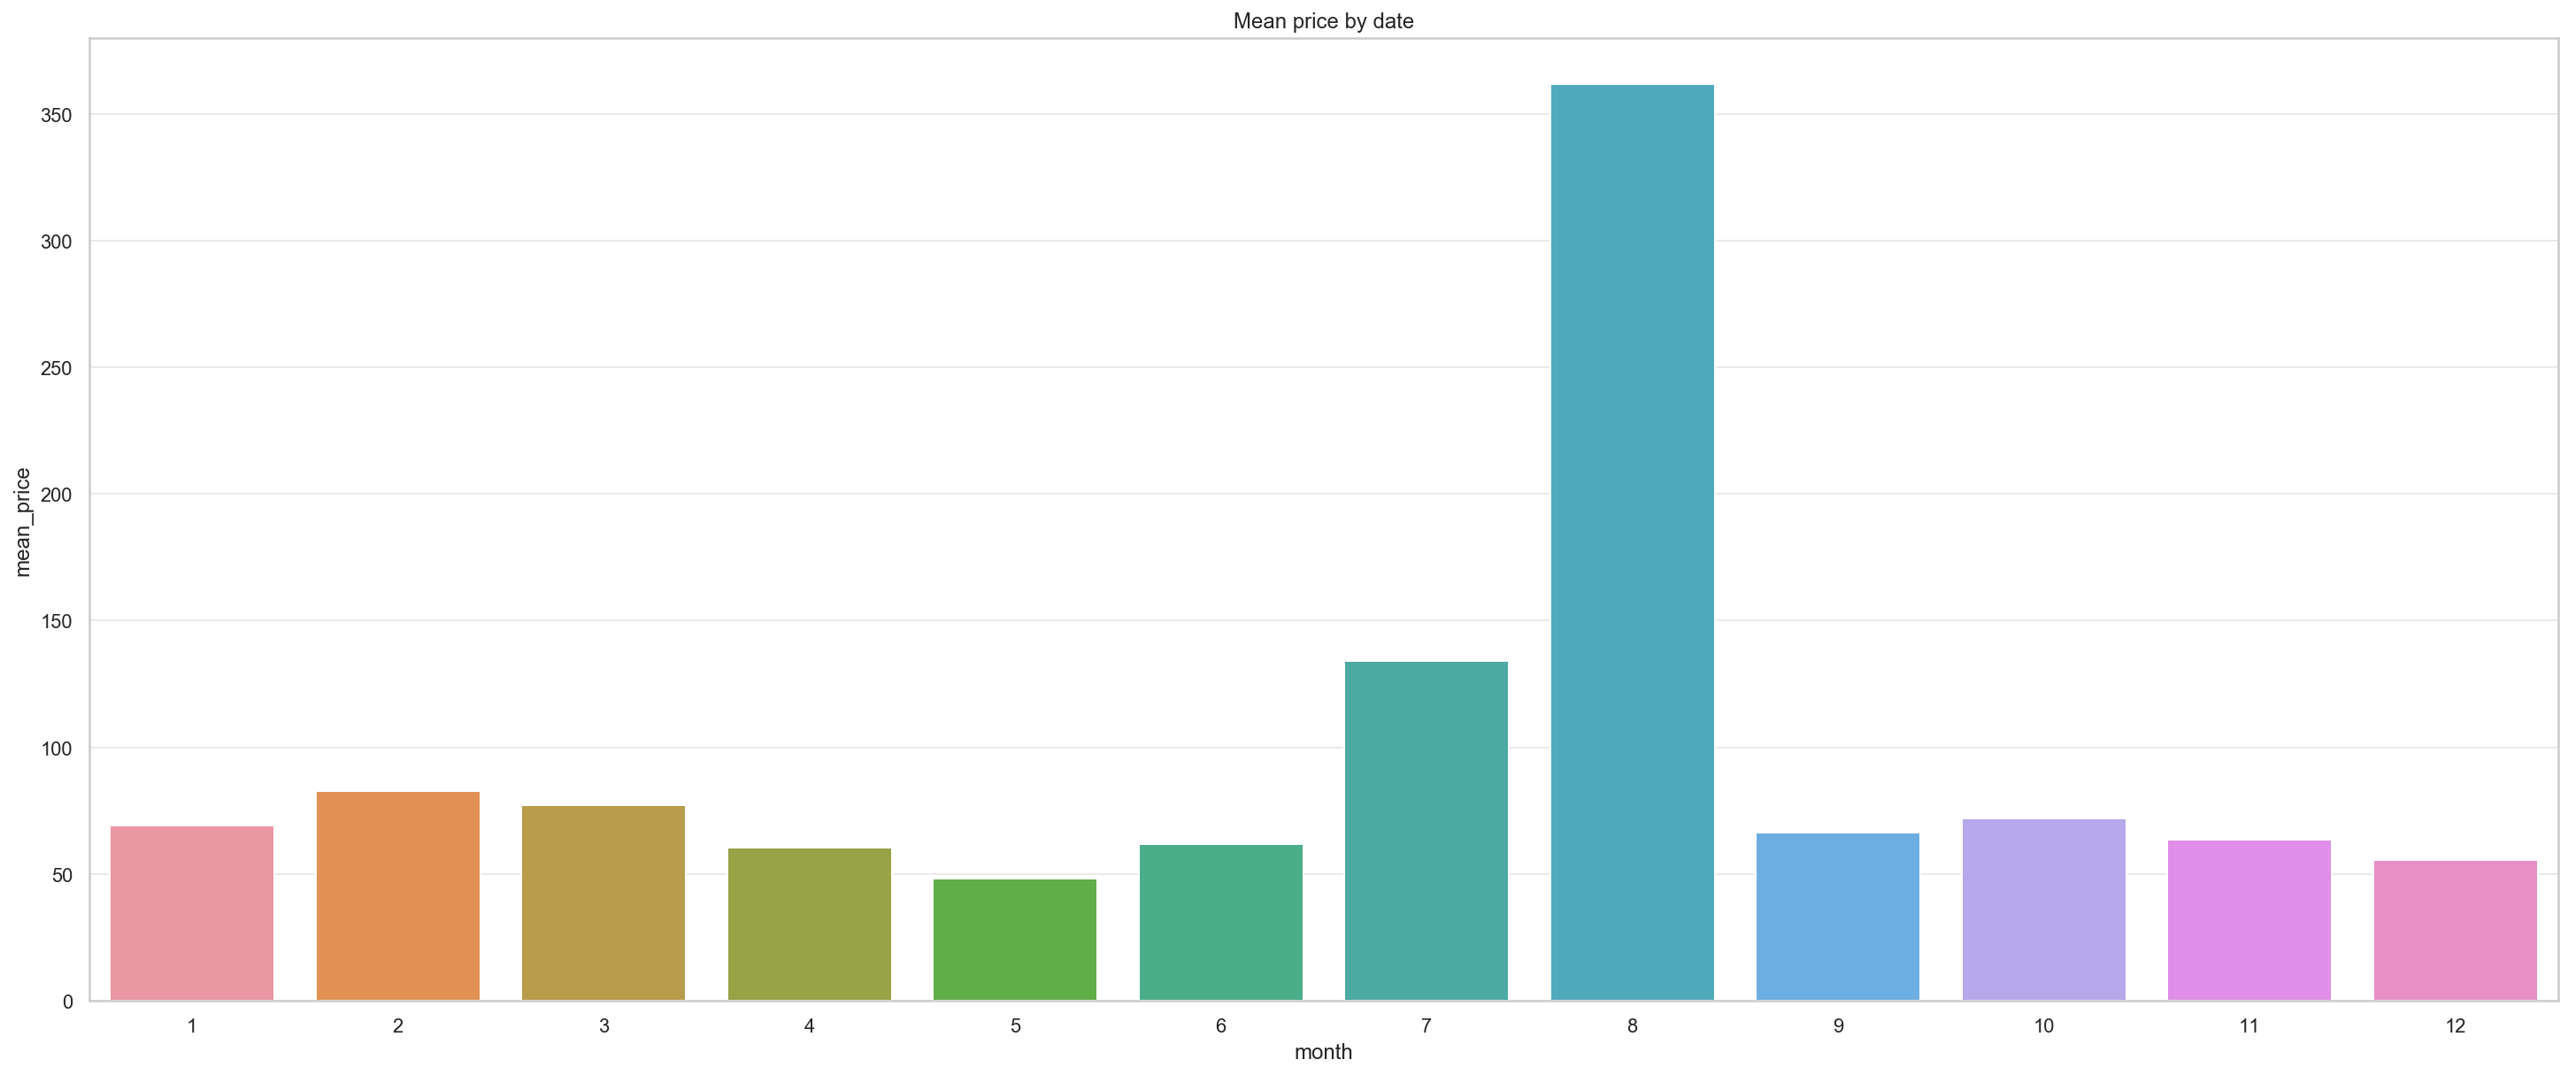

In [37]:
fig, ax = plt.subplots(figsize=(25, 10))
g = sns.barplot(
    x="month",
    y="mean_price",
    data=df1.groupby(pd.to_datetime(df1.dateAdded).dt.month)
    .apply(lambda df: df.prices_amountMax.mean())
    .reset_index()
    .rename(columns={"dateAdded": "month", 0: "mean_price"}),
    ax=ax,
)
ax.set_title("Mean price by date")

## Question 7

In [38]:
from matplotlib import colors as mcolors

list_colors = (
    df1.explode("list_colors")
    .list_colors.value_counts()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"index": "color", "list_colors": "count"})
    .color.values
)
matplot_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)


def find_best_color_match(c):
    return sorted(matplot_colors.items(), key=lambda tup: -fuzz.ratio(tup[0], c))[0][1]


custom_palette = list(map(find_best_color_match, list_colors))

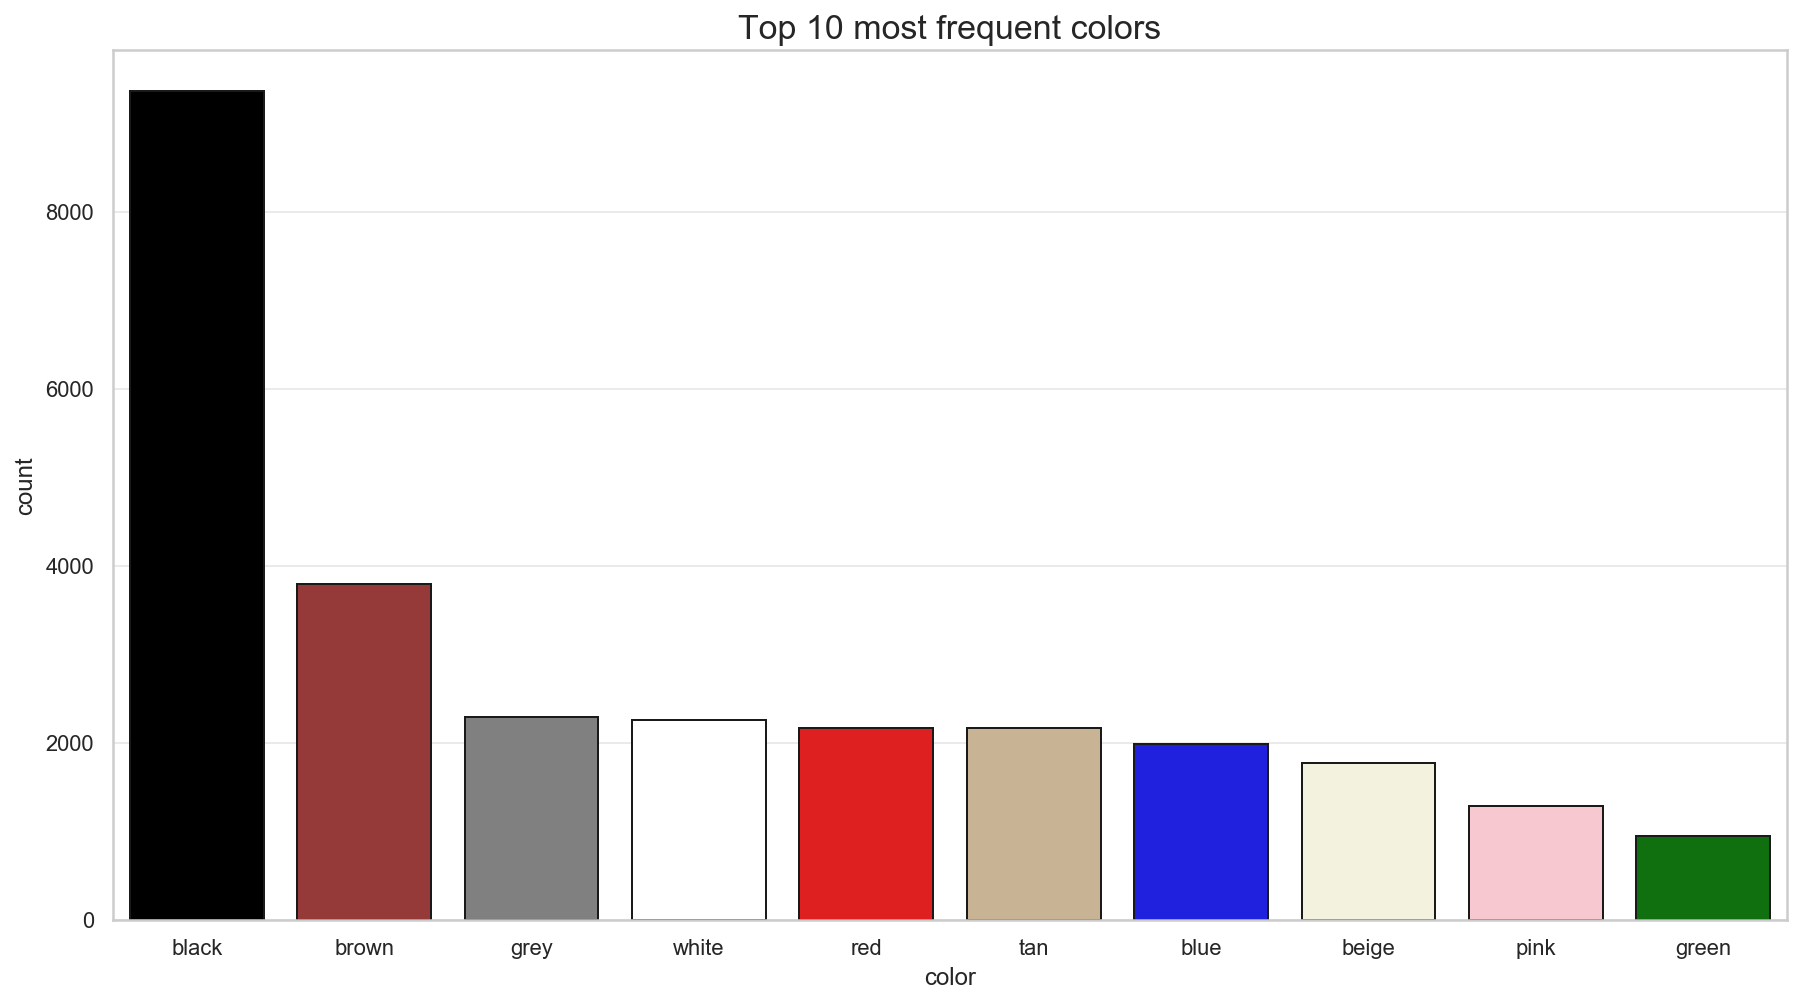

In [39]:
sns.set_context(rc = {'patch.linewidth': 1.0})
sns.barplot(
    x="color",
    y="count",
    data=df1.explode("list_colors")
    .list_colors.value_counts()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"index": "color", "list_colors": "count"}),
    palette=sns.color_palette(custom_palette),
    ax=new_axis(title="Top 10 most frequent colors"),
    edgecolor='k'
);


# Team Report


Possíveis próximos passos

- Um relato da discussão para se chegar a esse notebook e o que vocês acham que poderiam ser os próximos passos caso vocês estivessem em uma empresa trabalhando com esse problema.

- Finalmente, é meu interesse que haja uma discussão do que vocês usaram do que foi aprendido em aulas e o que vocês tiveram que aprender a mais para realizar o trabalho.

